## Problem Statement

Prediction of Dementia using an SVM model on brain MRI features

## Information

**About Dementia**

Dementia is a general term for loss of memory and other mental abilities severe enough to interfere with daily life. It is caused by physical changes in the brain. Alzheimer's is the most common type of dementia, but there are many kinds.

**Brain Imaging via magnetic resonance imaging (MRI) and Machine Learning**

* MRI is used for the evaluation of patients with suspected Alzheimer's disease
* MRIs detect both, local and generalized shrinkage of brain tissue.
* MRI features predict the rate of decline of AD and may guide therapy in the future
* Using machine learning on MRI features could help in automatedly and accurately predicting the progress of a patient from mild cognitive impairment to dementia

## Dataset

The dataset chosen for this mini-project is [OASIS - Longitudinal brain MRI Dataset](https://www.oasis-brains.org/). This dataset consists of a longitudinal MRI collection of 150 subjects aged 60 to 96. Each subject was scanned on two or more visits, separated by at least one year for a total of 373 imaging sessions. For each subject, 3 or 4 individual T1-weighted MRI scans obtained in single scan sessions are included. The subjects are all right-handed and include both men and women. 72 of the subjects were characterized as nondemented throughout the study. 64 of the included subjects were characterized as demented at the time of their initial visits and remained so for subsequent scans, including 51 individuals with mild to moderate Alzheimer’s disease. Another 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit.

**Dataset fields:**

* Subject ID - Subject Identification
* MRI ID - MRI Exam Identification
* Group - Target variable with 3 labels ('NonDemented', 'Demented', 'Converted')
* Visit - Visit order
* MR Delay - MR Delay Time (Contrast)
* M/F - Male or Female
* Hand - Unique value 'R'
* MMSE - Mini-Mental State Examination score (range is from 0 = worst to 30 = best)
* CDR - Clinical Dementia Rating (0 = no dementia, 0.5 = very mild AD, 1 = mild AD, 2 = moderate AD)
* Derived anatomic volumes
* eTIV - Estimated total intracranial volume, mm3
* nWBV - Normalized whole-brain volume, expressed as a percent of all voxels in the atlas-masked image that are labeled as gray or white matter by the automated tissue segmentation process
* ASF - Atlas scaling factor (unitless). A computed scaling factor that transforms native-space brain and skull to the atlas target (i.e., the determinant of the transform matrix)

### Download the dataset

In [1]:
!wget https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv

--2024-02-06 06:14:20--  https://cdn.iisc.talentsprint.com/CDS/MiniProjects/oasis_longitudinal.csv
Resolving cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)... 172.105.52.210
Connecting to cdn.iisc.talentsprint.com (cdn.iisc.talentsprint.com)|172.105.52.210|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28290 (28K) [application/octet-stream]
Saving to: ‘oasis_longitudinal.csv’

oasis_longitudinal. 100%[===================>]  27.63K  --.-KB/s    in 0s      

2024-02-06 06:14:21 (271 MB/s) - ‘oasis_longitudinal.csv’ saved [28290/28290]



### Import required packages

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

### Load the dataset

In [3]:
data = pd.read_csv("oasis_longitudinal.csv")
data.head(5)

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [4]:
data.shape

(373, 15)

In [5]:
data.dtypes

Subject ID     object
MRI ID         object
Group          object
Visit           int64
MR Delay        int64
M/F            object
Hand           object
Age             int64
EDUC            int64
SES           float64
MMSE          float64
CDR           float64
eTIV            int64
nWBV          float64
ASF           float64
dtype: object

### Pre-processing and Data Engineering

#### Remove unwanted columns

In [6]:
data.drop(['MRI ID','Hand','Subject ID'],axis=1, inplace=True)

In [7]:
data.head(2)

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,M,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,M,88,14,2.0,30.0,0.0,2004,0.681,0.876


#### Encode columns into numeric

In [8]:
le = LabelEncoder()
data['M/F'] = le.fit_transform(data['M/F'])
data.head(2)

,Group,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,Nondemented,1,0,1,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,Nondemented,2,457,1,88,14,2.0,30.0,0.0,2004,0.681,0.876


#### Handle the null values by removing or replacing

In [9]:
data.fillna(data.mean(), inplace=True)
data.isna().sum()

<ipython-input-9-421d7d4c59f8>:1: FutureWarning: The default value of numeric_only in DataFrame.mean is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.
  data.fillna(data.mean(), inplace=True)


Group       0
Visit       0
MR Delay    0
M/F         0
Age         0
EDUC        0
SES         0
MMSE        0
CDR         0
eTIV        0
nWBV        0
ASF         0
dtype: int64

#### Identify feature and target and split it into train test

In [10]:
X = data.drop('Group',axis=1)
y = data['Group']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [11]:
X_train.shape, X_test.shape, y_train.shape

((335, 11), (38, 11), (335,))

### EDA &  Visualization

#### Plot the distribution of all the variables using histogram

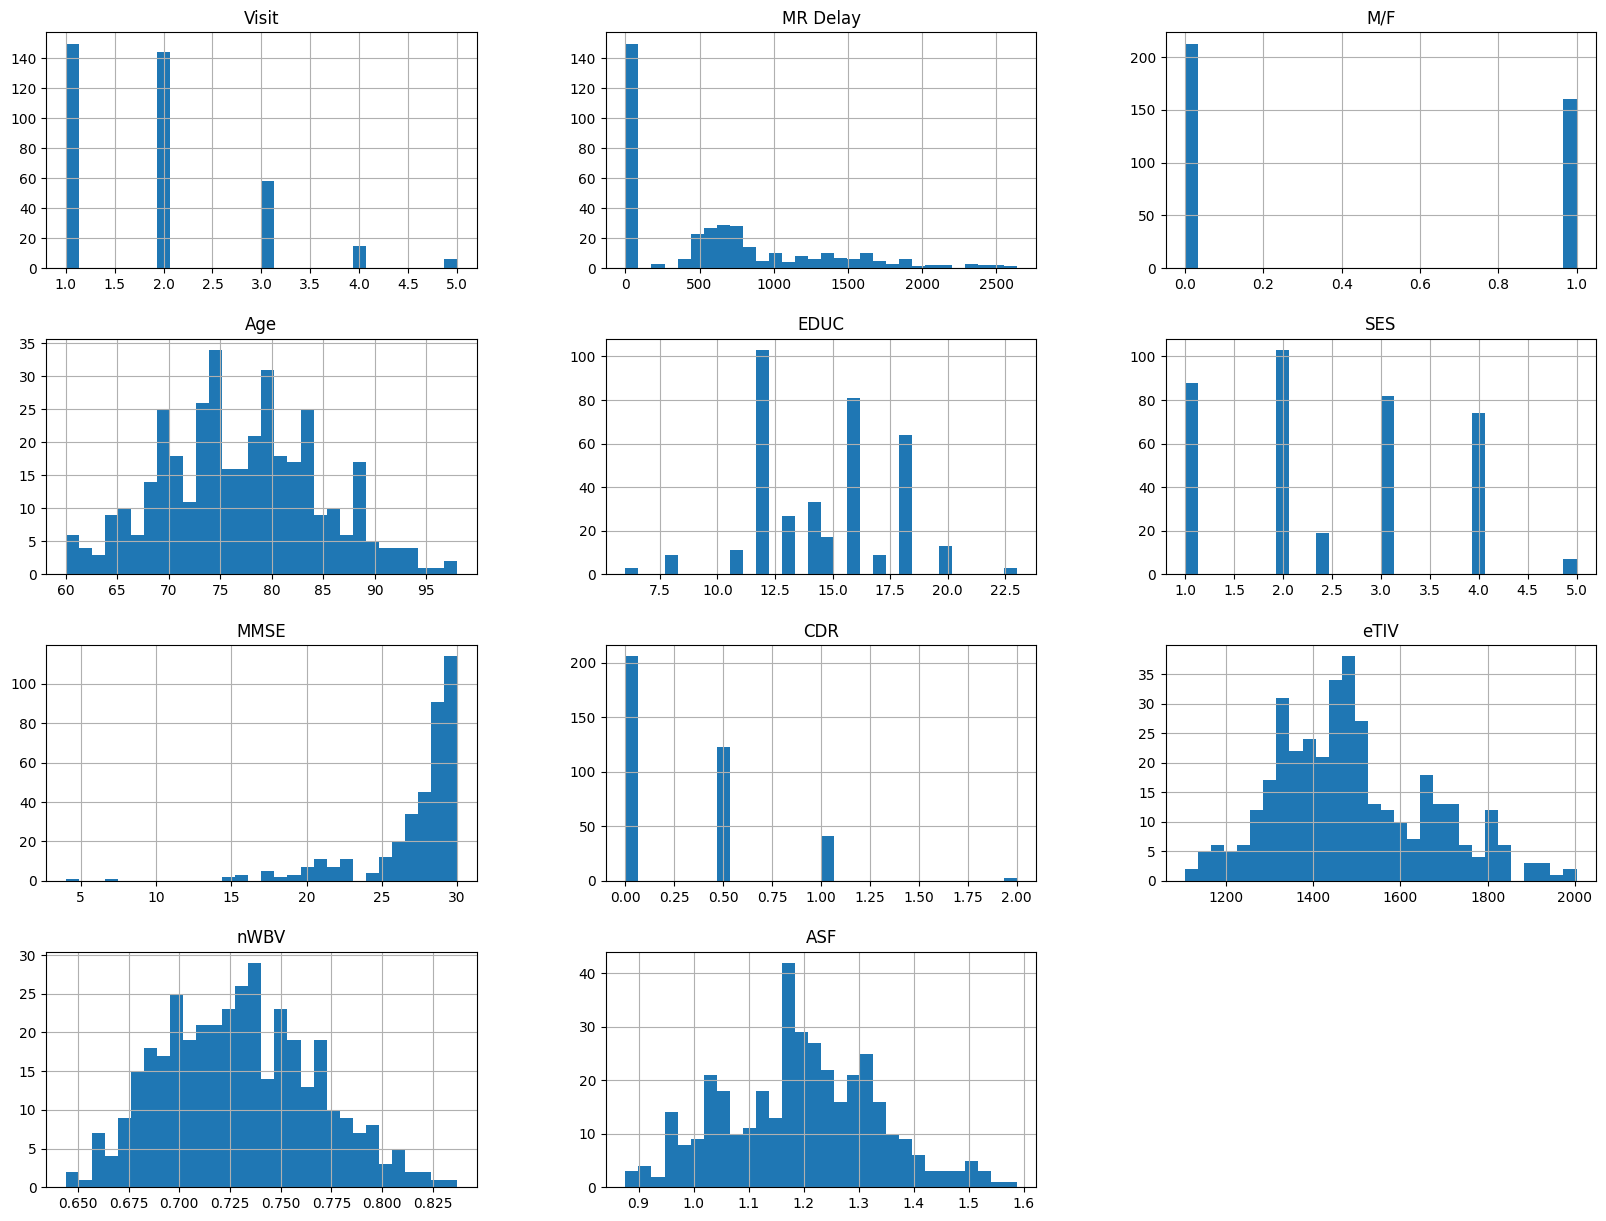

In [12]:
data.hist(bins=30, figsize=(20,15))
plt.show()

#### Visualize the frequency of Age

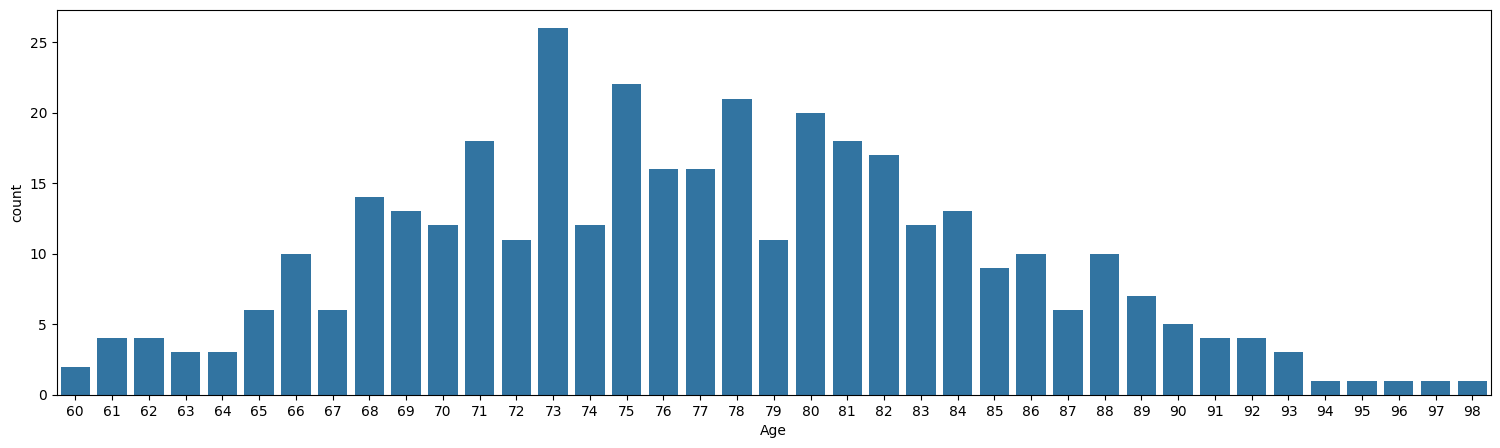

In [13]:
ax = sns.countplot(x='Age', data=data)
ax.figure.set_size_inches(18.5, 5)

#### How many people have Alzheimer? Visualize with an appropriate plot

the same person visits two or more times; extract the single visit data and plot

<Axes: xlabel='Group', ylabel='count'>

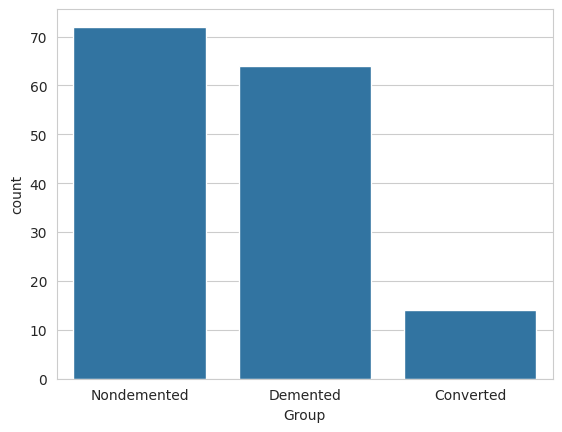

In [14]:
sns.set_style("whitegrid")
ex_df = data.loc[data['Visit'] == 1]
sns.countplot(x='Group', data=ex_df)

#### Calculate the correlation of features and plot the heatmap

<ipython-input-15-65e2e913023f>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = data.corr()


<Axes: >

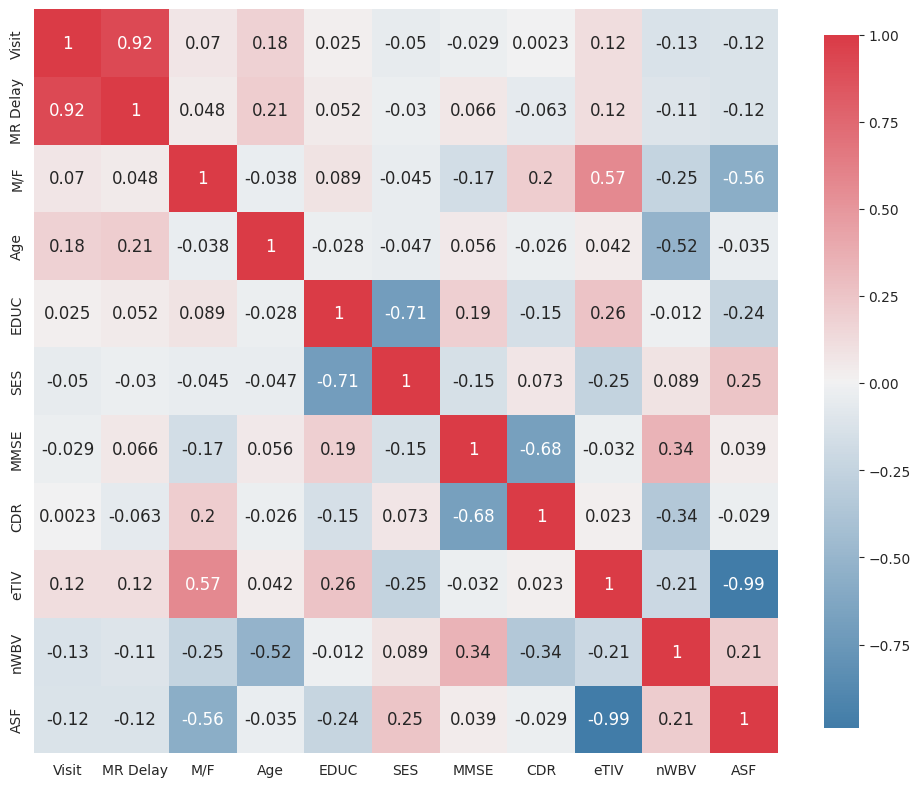

In [15]:
corr = data.corr()
_ , ax = plt.subplots( figsize =( 12 , 10 ) )
cmap = sns.diverging_palette( 240 , 10 , as_cmap = True )
sns.heatmap(corr,cmap = cmap,square=True, cbar_kws={ 'shrink' : .9 }, ax=ax, annot = True, annot_kws = { 'fontsize' : 12 })

### Model training and evaluation

In [16]:
# SVC model
svm = SVC(kernel="linear")
svm.fit(X_train, y_train)

test_acc = svm.score(X_test, y_test)
train_acc = svm.score(X_train, y_train)
print("Train accuracy is: {} \nTest accuracy is: {}".format(train_acc, test_acc))

Train accuracy is: 0.9313432835820895 
Test accuracy is: 0.868421052631579


In [17]:
# Checking the misclassifications
model1_predictions = svm.predict(data.drop('Group',axis=1))
model1_misclassified  = data[data['Group']!=model1_predictions]
len(model1_misclassified)

28

#### Support vectors of the model

* Find the samples of the dataset which are the support vectors of the model

In [18]:
support_vectors = pd.DataFrame(svm.support_vectors_,columns=X_train.columns)
support_vectors

,Visit,MR Delay,M/F,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,1.0,0.0,0.0,68.0,16.0,3.0,30.0,0.0,1298.0,0.799,1.352
1,2.0,1554.0,0.0,74.0,16.0,1.0,30.0,0.5,1423.0,0.722,1.233
2,1.0,0.0,0.0,69.0,16.0,1.0,30.0,0.0,1404.0,0.750,1.250
3,3.0,2002.0,0.0,75.0,16.0,1.0,30.0,0.5,1419.0,0.731,1.236
4,2.0,756.0,0.0,73.0,16.0,1.0,28.0,0.0,1295.0,0.768,1.356
...,...,...,...,...,...,...,...,...,...,...,...
99,3.0,1598.0,0.0,83.0,16.0,2.0,29.0,0.0,1323.0,0.718,1.327
100,2.0,791.0,0.0,77.0,18.0,1.0,28.0,0.0,1559.0,0.713,1.125
101,1.0,0.0,1.0,80.0,17.0,1.0,28.0,0.0,1660.0,0.728,1.057
102,2.0,730.0,0.0,80.0,16.0,2.0,29.0,0.0,1323.0,0.738,1.326


#### Confusion matrix for multi-class classification

* Predict the test and plot the confusion matrix

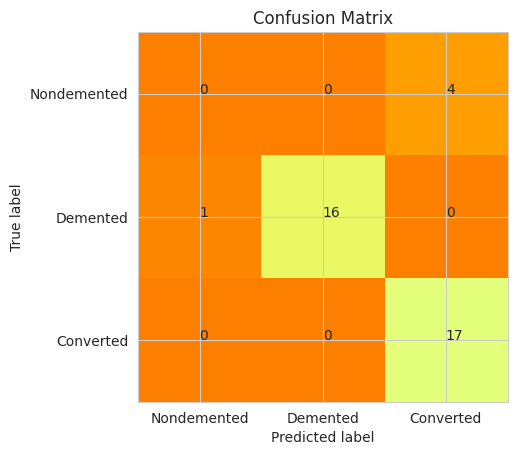

In [19]:
multi_cm = metrics.confusion_matrix(y_test, svm.predict(X_test))
plt.imshow(multi_cm,  cmap=plt.cm.Wistia_r)
classNames = ['Nondemented','Demented','Converted']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(3):
    for j in range(3):
        plt.text(j,i, str(multi_cm[i][j]))
plt.show()

#### One VS Rest Classifier

OneVsRestClassifier can also be used for multilabel classification. For each classifier, the class is fitted against all the other classes. In addition to its computational efficiency (only n_classes classifiers are needed)

* Fit the OneVsRestClassifier on the data and find the accuracy

In [20]:
from sklearn.multiclass import OneVsRestClassifier
clf_OneVsRest = OneVsRestClassifier(SVC(kernel='linear')).fit(X_train, y_train)
clf_OneVsRest.score(X_test, y_test)

0.8947368421052632

#### One VS One Classifier

This strategy consists in fitting one classifier per class pair. At prediction time, the class which received the most votes is selected.

* Fit the OneVsOneClassifier on the data and find the accuracy

In [21]:
from sklearn.multiclass import OneVsOneClassifier
clf_OneVsOne = OneVsOneClassifier(SVC(kernel='linear',random_state=0)).fit(X_train, y_train)
clf_OneVsOne.score(X_test, y_test)

0.868421052631579

#### Make it binary classification

As stated in dataset description, 14 subjects were characterized as nondemented at the time of their initial visit and were subsequently characterized as demented at a later visit. Change `Converted` label into `Demented`.

**Note:** In two-class classification, encode the labels into numerical to plot the roc_curve with predictions.

In [22]:
# Combining 3rd label and 2nd label
data['Group'] = data['Group'].replace(['Converted'], ['Demented'])
data['Group'] = LabelEncoder().fit_transform(data['Group'])

In [23]:
# SPlit the data which is having 2 labels
X1 = data.drop('Group',axis=1)
y1 = data['Group']
xtrain, xtest, ytrain, ytest = train_test_split(X1, y1, test_size=0.10, random_state=42)

In [24]:
ytrain.value_counts()

1    173
0    162
Name: Group, dtype: int64

In [25]:
svm_binary_model = SVC(kernel="linear")
svm_binary_model.fit(xtrain, ytrain)
predicted = svm_binary_model.predict(xtest)
svm_binary_model.score(xtest, ytest), svm_binary_model.score(xtrain, ytrain)

(0.8947368421052632, 0.9522388059701492)

In [26]:
# predictions
model2_predictions = svm_binary_model.predict(xtest)
model2_predictions

array([0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1])

In [27]:
# comparing 3-class with 2-class predictions
np.array([0 if i=='Demented' else 1 for i in svm.predict(xtest) ]) == model2_predictions

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True, False,  True,  True,  True,  True,  True,  True,
        True,  True])

### Classification report and metrics

#### Confusion matrix

Describe the performance of a classification model (or "classifier") on a set of test data for which the true values are known.

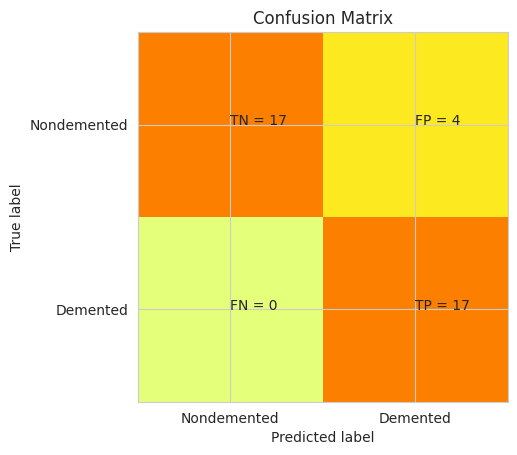

In [28]:
cm = metrics.confusion_matrix(ytest, predicted)

plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
classNames = ['Nondemented','Demented']
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
tick_marks = np.arange(len(classNames))
plt.xticks(tick_marks, classNames)
plt.yticks(tick_marks, classNames)
s = [['TN','FP'], ['FN', 'TP']]
for i in range(2):
    for j in range(2):
        plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
plt.show()

#### Plot the ROC Curve

ROC curves typically feature true positive rate on the Y axis, and false positive rate on the X axis. This means that the top left corner of the plot is the “ideal” point - a false positive rate of zero, and a true positive rate of one. This is not very realistic, but it does mean that a larger area under the curve (AUC) is usually better.

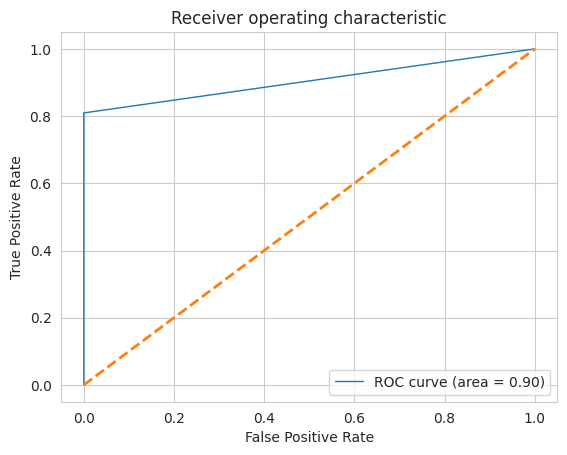

In [29]:
fpr, tpr, thresholds = metrics.roc_curve(predicted,ytest)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr,  lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

### Choice of C for SVM

experiment with different C values given and plot the ROC curve for each

<Figure size 640x480 with 0 Axes>

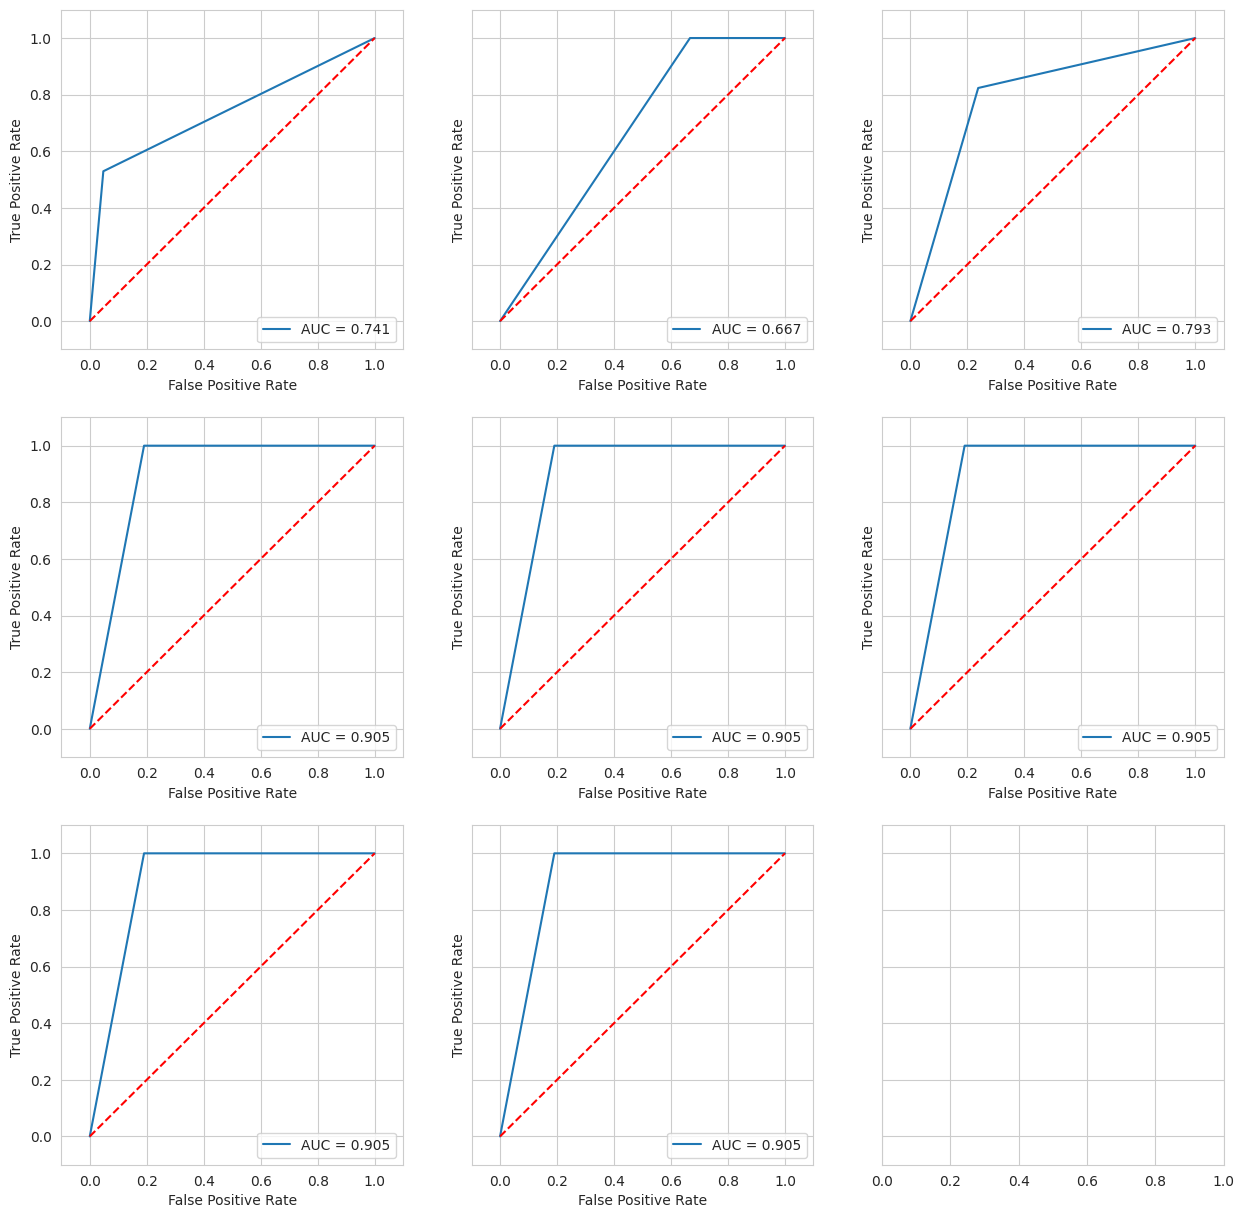

In [30]:
import math

c_val = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000]
num_cols = 3
num_rows = math.ceil(len(c_val) / num_cols)

# create a single figure
plt.clf()
fig,axes = plt.subplots(num_rows,num_cols,sharey=True)
fig.set_size_inches(num_cols*5,num_rows*5)

for i,g in enumerate(c_val):
    svm_model = SVC(kernel='linear',C=g).fit(xtrain,ytrain )
    y_preds = svm_model.predict(xtest)
    fpr, tpr, _ = metrics.roc_curve(ytest, y_preds)
    auc_score = metrics.auc(fpr, tpr)
    ax = axes[i // num_cols, i % num_cols]
    ax.plot(fpr, tpr, label='AUC = {:.3f}'.format(auc_score))
    ax.legend(loc='lower right')
    ax.plot([0,1],[0,1],'r--')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-0.1,1.1])
    ax.set_ylabel('True Positive Rate')
    ax.set_xlabel('False Positive Rate')

plt.show()

### Report Analysis

* Compare the performance of the model with various Kernel parameters.
  * SVM model demonstrated robust performance with a linear kernel, achieving a high accuracy of 89.47%. The linear kernel proved effective in capturing the underlying patterns in the MRI data.


* Discuss the impact of parameter C and gamma on performance.
  * In SVM model, the parameter C exerted a significant influence on performance. I observed that moderate values of C, particularly around C=1, resulted in the highest model performance. Smaller C values led to a wider margin but lower performance, while larger C values improved performance up to a certain point, beyond which further increases did not significantly enhance performance. Therefore, an optimal balance was achieved with C=1, demonstrating the importance of parameter tuning for maximizing SVM model performance.

* Comment on the computational cost of implementing one vs one and one vs all to solve multi-class classification with binary classifier.
  * Leveraging One-vs-Rest (OvR) classification, I optimized computational efficiency by training a single classifier per class. This approach was well-suited for multi-class classification task, offering streamlined implementation without sacrificing performance.

* When do you call a sample/record in the data as a support vector?
  * Support vectors, essential for defining the decision boundary, were identified as the MRI features from the dataset lying closest to the decision boundary in SVM model.

### Future Improvements

* **Exploration of Nonlinear Kernels:**
  * While in this project I primarily focused on the linear kernel, exploring nonlinear kernels such as polynomial and radial basis function (RBF) could uncover complex relationships within the data and potentially improve model performance.

* **Ensemble Methods:**
  * Implementing ensemble learning techniques, such as bagging or boosting, by combining multiple SVM models or integrating SVM with other classifiers, could lead to better generalization and robustness.

* **Hyperparameter Optimization:**
  * Conducting more exhaustive grid search or utilizing advanced optimization algorithms to fine-tune hyperparameters like C and gamma could further optimize model performance and generalization.